In [8]:
#imports and settings
import pandas as pd 
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from matplotlib import pyplot as plt 

In [9]:
df = pd.read_csv('/Users/Jakub/loan.csv', low_memory = False)

In [28]:
#Returns a random sample of items - 30% so the dataset is easy to work with
df_sample = df.sample(frac = 0.3)
df_sample.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
106324,6552399,8104403,16000.0,16000.0,15950.0,36 months,10.64,521.10,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,34600.0,NaN,NaN,NaN
644352,57692311,61445024,25000.0,25000.0,25000.0,60 months,19.99,662.21,E,E4,...,NaN,NaN,NaN,NaN,NaN,NaN,58400.0,NaN,NaN,NaN


In [29]:
#Analyzing target variable - loan_status
df_sample['loan_status'].value_counts()

Current                                                180449
Fully Paid                                              62414
Charged Off                                             13601
Late (31-120 days)                                       3465
Issued                                                   2557
In Grace Period                                          1884
Late (16-30 days)                                         706
Does not meet the credit policy. Status:Fully Paid        575
Default                                                   346
Does not meet the credit policy. Status:Charged Off       217
Name: loan_status, dtype: int64

In [30]:
#getting rid of loans with statuses we do not care about
#we do not care about current loans 
#explanation of difference between charged off and default https://help.lendingclub.com/hc/en-us/articles/216127747
#we only care about those loans that are either fully paid or are
#very late
#too little examples with "does not meet the credit policy" to care about these...
mask = df_sample['loan_status'].isin(['Fully Paid','Charged Off','Default'])
df_sample = df_sample[mask]
df_sample['loan_status'].value_counts()


Fully Paid     62414
Charged Off    13601
Default          346
Name: loan_status, dtype: int64

In [31]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Fully Paid':
        return False
    else:
        return True
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

False    62414
True     13947
Name: Late_Loan, dtype: int64

In [32]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)/10
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['id','member_id','issue_d','loan_status','url','zip_code','policy_code','application_type','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line'],axis =1)

#replace missing values with Unknown value or mean when feature is numerical
df_sample['emp_title'].fillna('Unknown',inplace = True)
df_sample['title'].fillna('Unknown',inplace = True)
df_sample['revol_util'].fillna(df_sample['revol_util'].mean(),inplace = True)
df_sample['collections_12_mths_ex_med'].fillna(df_sample['collections_12_mths_ex_med'].mean(),inplace = True)

df_sample.isnull().sum() #there are no missing values left 

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
purpose                       0
title                         0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
Late_Loan                     0
dtype: int64

In [33]:
#old categorical emp_length feature
df_sample['emp_length'].value_counts()

10+ years    23167
2 years       7082
< 1 year      6347
3 years       6155
5 years       5359
1 year        5086
4 years       4809
6 years       4513
7 years       4315
8 years       3585
n/a           3004
9 years       2939
Name: emp_length, dtype: int64

In [34]:
#new numerical emp_length feature

def EmpLength(year):
    if year == '< 1 year':
        return 0.5
    elif year == 'n/a': #assuming that if not filled out employments was < 1 
        return 0.5
    elif year == '10+ years':
        return 10
    else:
        return float(year.rstrip(' years'))
        
df_sample['emp_length_num'] = df_sample['emp_length'].map(EmpLength)
df_sample = df_sample.drop('emp_length',axis =1 )
df_sample['emp_length_num'].value_counts()

10.0    23167
0.5      9351
2.0      7082
3.0      6155
5.0      5359
1.0      5086
4.0      4809
6.0      4513
7.0      4315
8.0      3585
9.0      2939
Name: emp_length_num, dtype: int64

In [35]:
df_sample['title_new'] = df_sample['title'].map(str)

In [36]:
#datatypes of features 
# object = string ? 
df_sample.dtypes.value_counts()

float64    15
object      8
bool        1
dtype: int64

In [37]:
#cleaned and transformed data ready for analysis and ML 
#numerical features - means 
print(df_sample.select_dtypes(include=['float64']).apply(np.mean).apply(str))

# categorical variables 
print(df_sample.select_dtypes(include=['object']).columns)

# target variable - boolean

print(df_sample.select_dtypes(include=['bool']).columns)



loan_amnt                        13517.4388759
int_rate                         13.7785290921
installment                      416.810293867
annual_inc                       72182.8195833
dti                               16.597453543
delinq_2yrs                     0.253624232265
inq_last_6mths                  0.851979413575
open_acc                         10.9445528477
pub_rec                           0.1439085397
revol_bal                        15173.2449942
revol_util                       54.2399541308
total_acc                        25.0143004937
collections_12_mths_ex_med    0.00761058932946
acc_now_delinq                0.00309058288917
emp_length_num                   5.66395804141
dtype: object
Index([u'term', u'grade', u'emp_title', u'home_ownership', u'purpose',
       u'title', u'addr_state', u'title_new'],
      dtype='object')
Index([u'Late_Loan'], dtype='object')


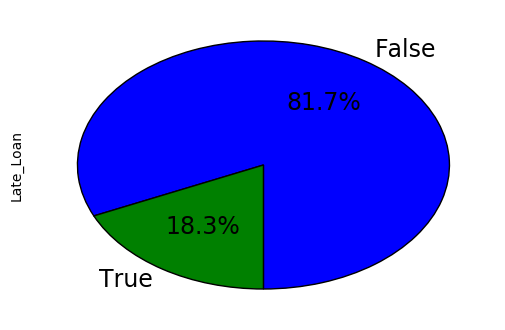

In [42]:
#distribution of our class/targer variable Late_Loan , True if loan was late. 

df_sample['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%1.1f%%', startangle=270, fontsize=17)
plt.show()